<a href="https://colab.research.google.com/github/shicong621/Colab/blob/main/task1_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class Challenge: Image Classification of COVID-19 X-rays
# Task 1 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Binary Classification: COVID-19 vs. Normal

In [ ]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
tf.__version__

'2.8.0'

#### Load Image Data

In [ ]:
DATA_LIST = os.listdir('two/train')
DATASET_PATH  = 'two/train'
TEST_DIR =  'two/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 16  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 40
LEARNING_RATE = 0.0002 # start off with high rate first 0.001 and experiment with reducing it gradually 
DROP_OUT = 0.25

#### Generate Training and Validation Batches

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="binary")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",seed=42,
                                                  class_mode="binary")

Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


/Users/shicongwang/miniforge3/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [ ]:
from tensorflow.keras.layers import Flatten, Dense , Dropout
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
import time

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg16 = VGG16(weights="imagenet", 
                   include_top=False, 
                   input_shape= (224, 224, 3))
vgg16.trainable = False ## Not trainable weights

model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(404,activation='relu'))
model.add(Dropout(DROP_OUT))
model.add(Dense(66,activation='relu'))
model.add(Dropout(DROP_OUT))
model.add(Dense(66,activation='relu',name='dense_feature'))
model.add(Dense(1,activation='sigmoid'))

model.summary() 

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_11 (Flatten)        (None, 25088)             0         
                                                                 
 dense_32 (Dense)            (None, 404)               10135956  
                                                                 
 dropout_16 (Dropout)        (None, 404)               0         
                                                                 
 dense_33 (Dense)            (None, 66)                26730     
                                                                 
 dropout_17 (Dropout)        (None, 66)                0         
                                                                 
 dense_feature (Dense)       (None, 66)              

### [5 points] Train Model


In [ ]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
t_start = time.time()

model.compile(
    optimizer= opt,
    loss='BinaryCrossentropy',
    metrics=['accuracy'],
)

history = model.fit(train_batches,
            steps_per_epoch=STEP_SIZE_TRAIN,
            validation_data=valid_batches,
            validation_steps=STEP_SIZE_VALID,
            epochs=NUM_EPOCHS)

7
2


/Users/shicongwang/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/shicongwang/miniforge3/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/shicongwang/miniforge3/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/40


2022-05-01 16:32:02.204490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.7170 - accuracy: 0.5341

2022-05-01 16:32:17.383194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 18s 3s/step - loss: 0.7170 - accuracy: 0.5341 - val_loss: 0.5210 - val_accuracy: 1.0000
Epoch 2/40
6/6 [==============================] - 3s 416ms/step - loss: 0.5759 - accuracy: 0.7386 - val_loss: 0.4499 - val_accuracy: 0.8750
Epoch 3/40
6/6 [==============================] - 3s 427ms/step - loss: 0.5124 - accuracy: 0.7727 - val_loss: 0.2816 - val_accuracy: 0.9375
Epoch 4/40
6/6 [==============================] - 3s 422ms/step - loss: 0.5106 - accuracy: 0.7500 - val_loss: 0.3371 - val_accuracy: 0.8125
Epoch 5/40
6/6 [==============================] - 3s 451ms/step - loss: 0.3004 - accuracy: 0.9205 - val_loss: 0.1993 - val_accuracy: 0.9375
Epoch 6/40
6/6 [==============================] - 3s 473ms/step - loss: 0.3555 - accuracy: 0.8864 - val_loss: 0.1765 - val_accuracy: 0.9375
Epoch 7/40
6/6 [==============================] - 3s 415ms/step - loss: 0.4671 - accuracy: 0.8068 - val_loss: 0.2235 - val_accuracy: 0.9375
Epoch 8/40
6/6 [=================

#### [5 points] Plot Accuracy and Loss During Training

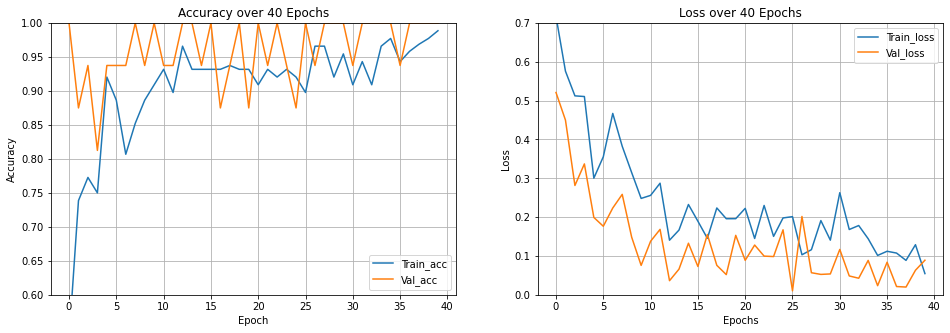

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))
#plot acc graph
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train_acc')
plt.plot(history.history['val_accuracy'], label='Val_acc')
plt.title("Accuracy over 40 Epochs")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.6, 1])
plt.legend(loc='lower right')
plt.grid(True)

# plot loss graph
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label = 'Val_loss')
plt.title("Loss over 40 Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0,0.7])
plt.legend(loc='upper right')
plt.grid(True)

#### Plot Test Results

Found 18 images belonging to 2 classes.


/var/folders/_n/3x186dbd2fb0356vs80d2w7h0000gn/T/ipykernel_21689/3278958914.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(eval_generator,18,verbose=1)
2022-04-29 13:13:34.109594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 27ms/step
covid/nejmoa2001191_f3-PA.jpeg


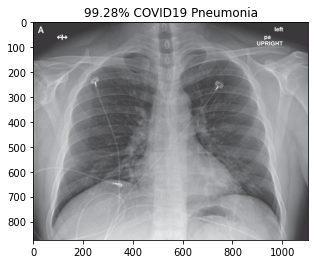

covid/nejmoa2001191_f4.jpeg


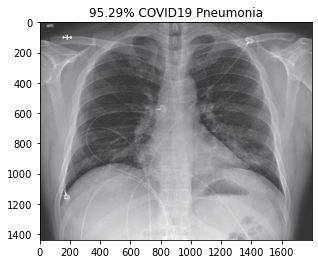

covid/nejmoa2001191_f5-PA.jpeg


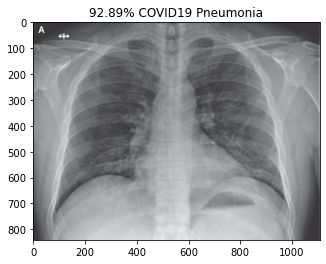

covid/radiol.2020200490.fig3.jpeg


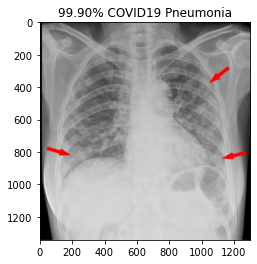

covid/ryct.2020200028.fig1a.jpeg


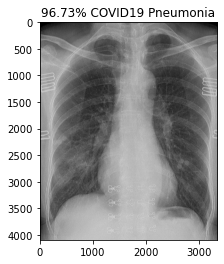

covid/ryct.2020200034.fig2.jpeg


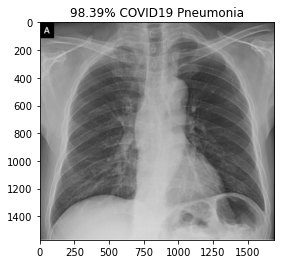

covid/ryct.2020200034.fig5-day0.jpeg


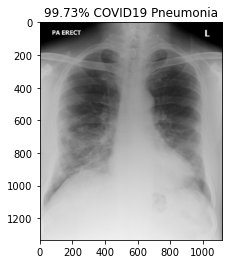

covid/ryct.2020200034.fig5-day4.jpeg


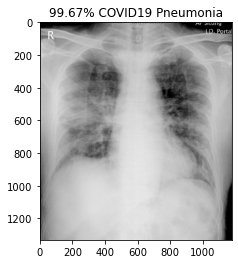

covid/ryct.2020200034.fig5-day7.jpeg


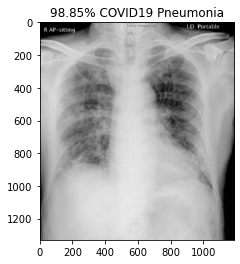

normal/NORMAL2-IM-1385-0001.jpeg


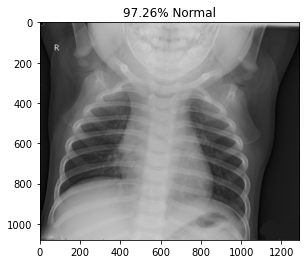

normal/NORMAL2-IM-1396-0001.jpeg


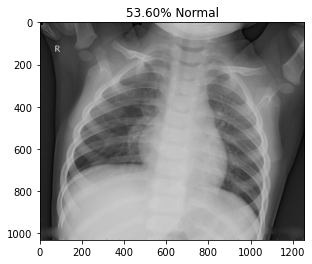

normal/NORMAL2-IM-1400-0001.jpeg


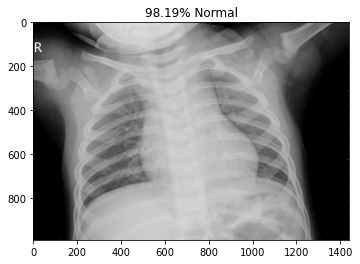

normal/NORMAL2-IM-1401-0001.jpeg


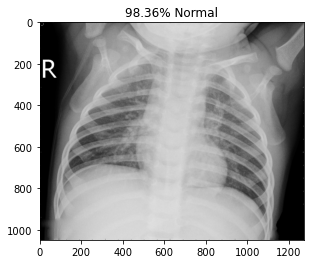

normal/NORMAL2-IM-1406-0001.jpeg


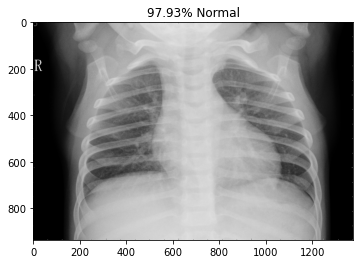

normal/NORMAL2-IM-1412-0001.jpeg


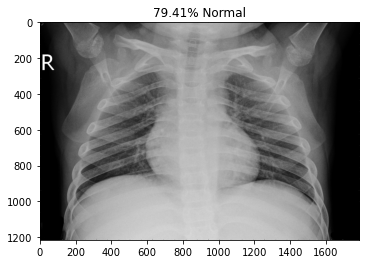

normal/NORMAL2-IM-1419-0001.jpeg


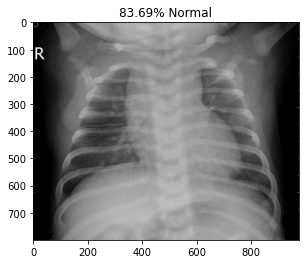

normal/NORMAL2-IM-1422-0001.jpeg


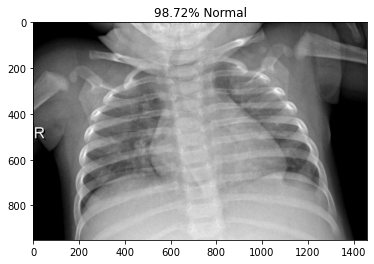

normal/NORMAL2-IM-1423-0001.jpeg


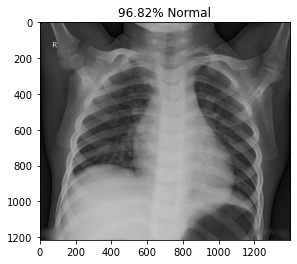

In [ ]:
import matplotlib.image as mpimg

test_datagen = ImageDataGenerator(rescale=1. / 255)
eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary")
eval_generator.reset()
pred = model.predict_generator(eval_generator,18,verbose=1)
for index, probability in enumerate(pred):
    image_path = TEST_DIR + "/" +eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    if image.ndim < 3:
        image = np.reshape(image,(image.shape[0],image.shape[1],1))
        image = np.concatenate([image, image, image], 2)
#         print(image.shape)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")
    plt.show()

In [ ]:
#auc in test data set
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

18


/var/folders/_n/3x186dbd2fb0356vs80d2w7h0000gn/T/ipykernel_21689/470443534.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),


18/18 [==============================] - 1s 30ms/step - loss: 0.0315 - accuracy: 1.0000
Test loss: 0.0314907506108284
Test accuracy: 1.0


In [ ]:
y_pred = pred > 0.5

mat = confusion_matrix(eval_generator.classes, y_pred)

print('Confusion Matrix')
target_names = ['Covid', 'Normal']
print(classification_report(eval_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
              precision    recall  f1-score   support

       Covid       1.00      1.00      1.00         9
      Normal       1.00      1.00      1.00         9

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

In [ ]:
pip install seaborn 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 KB 2.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


Found 130 images belonging to 2 classes.


2022-05-01 16:34:51.364272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/shicongwang/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/shicongwang/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


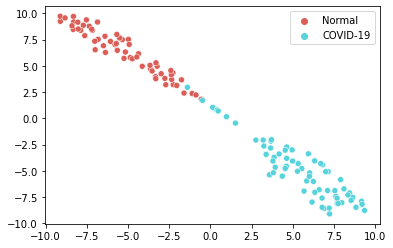

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

intermediate_layer_model = Model(inputs=model.input,
                  outputs=model.get_layer('dense_feature').output)
tsne_data_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                            batch_size=1,shuffle=False,seed=42,class_mode="binary")

vals = intermediate_layer_model.predict(tsne_data_generator)
visual = TSNE(n_components=2).fit_transform(vals)

c = tsne_data_generator.labels
labels = map(lambda x: "COVID-19" if x == 0 else "Normal", tsne_data_generator.labels)
scat=sns.scatterplot(x=visual[:,0],y=visual[:,1], hue=labels, palette=sns.color_palette("hls", 2))
handles,labels = scat.get_legend_handles_labels()
scat.legend(handles, ['Normal', 'COVID-19'])

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->